In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import QTable
from astropy import units as u
from astropy.coordinates import Distance

# Tabla de miembros:

In [2]:
members = QTable.read('./../data/raw/members.fit')
members = members.to_pandas()

# Tabla de clusters:

In [3]:
clusters = QTable.read('./../data/raw/clusters.fit')
clusters = clusters.to_pandas()
clusters = clusters.sort_values(by='N', ascending=False)

# Tabla de distancias

Esta tabla es recuperada de la tabla `external.gaiaedr3_distance`, donde las distancias son dadas en $\text{pc}$.

In [4]:
distance_members = QTable.read('./../data/raw/distances.fits')
distance_members = distance_members.to_pandas()

# Datos pedidos

La siguiente variable indica el cluster, donde a mayor número, menos número de miembros.

In [5]:
cluster_n = 1

La tabla de cúmulos se organizó de mayor a menor número de miembros. El `.iloc` escoge el cúmulo que es la fila $i$, y la ascensión recta y la declinación que son las columnas 3 y 4 de la tabla. 

Según el catálogo este es el punto más denso del cúmulo.

In [6]:
ra0 = clusters.iloc[cluster_n, 3]
dec0 = clusters.iloc[cluster_n, 4]

## Recolección de datos pedidos

Se crea una tabla con todos los datos del respectivo cúmulo:

In [7]:
cluster_members = members[members['Name'] == clusters.iloc[cluster_n, 0]]

Se crea una tabla con todas las distancias de los miembros del respectivo cúmulo.

In [8]:
members_distance = distance_members[distance_members['Name'] == clusters.iloc[cluster_n, 0]]

Se agrega las distancias de cada respectiva estrella a la anterior tabla:

In [9]:
cluster_members = pd.merge(cluster_members, members_distance[['GaiaDR3', 'r_med_geo']], how='left', on='GaiaDR3')

## Figura del cúmulo

Text(0, 0.5, 'Dec [deg]')

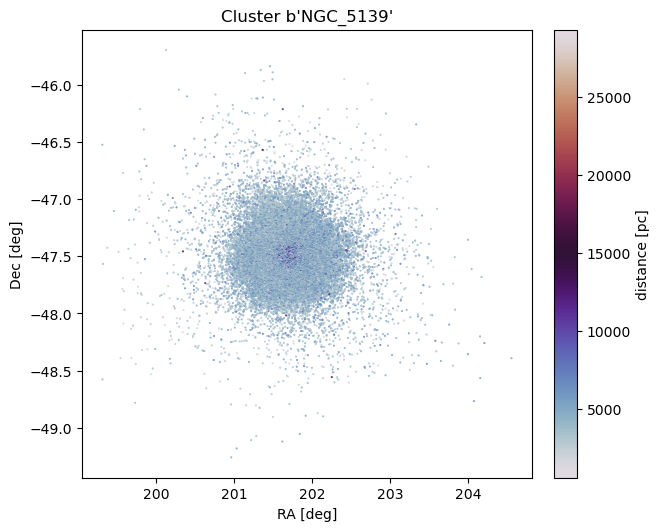

In [10]:
fig, ax = plt.subplots(figsize=(6.5, 5.2), constrained_layout=True)
cs = ax.scatter(
    cluster_members['RA_ICRS'],
    cluster_members['DE_ICRS'],
    c = cluster_members['r_med_geo'],
    s=0.2,
    vmin=min(cluster_members['r_med_geo']),
    vmax=max(cluster_members['r_med_geo']),
    cmap='twilight',
)

cb = fig.colorbar(cs)
cb.set_label("distance [pc]")

ax.set_title(f"Cluster {cluster_members['Name'][0]}")
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")

# Cálculo de la densidad de área del cúmulo

Se calcula la distancia de los miembros al punto más denso del cúmulo usando la siguiente fórmula: $$\cos{c} = \cos{a}\cos{b} + \sin{a}\sin{b}\cos{C}$$ donde $c$ sería la distancia que se quiere encontrar.

Para usar esta fórmula se debe hacer la respectiva geometría esférica en la bóveda celeste.

In [11]:
a = np.deg2rad(90 - dec0)
b = np.deg2rad(90 - cluster_members['DE_ICRS'])
C = np.deg2rad(ra0 - cluster_members['RA_ICRS'])

cosc = np.cos(a)*np.cos(b) + np.sin(a)*np.sin(b)*np.cos(C)
c = np.arccos(cosc)

cluster_distance_members = np.rad2deg(c)

Se crea un dataframe para concatenarlo a la tabla de miembros del cúmulo:

In [12]:
d_members = pd.DataFrame(
    {'d_members': cluster_distance_members}
)

Se halla la máxima distancia:

In [13]:
r_max = max(cluster_distance_members)

Se generan los radios hasta la distancia máxima para calcular la densidad de área por anillos:

In [14]:
rs = np.linspace(0, r_max, 50)

In [15]:
# calcula los radios medios de cada anillo
def mean_radii(radii):
    return (radii[1:] + radii[:-1])/2

# calcula el área de cada anillo
def ring_areas(radii):
    area0 = np.pi * radii[:-1]**2
    area1 = np.pi * radii[1:]**2
    return area1 - area0

# calcula la densidad de número de miembros en cada anillo
def ring_densities(areas, distances, radii):
    counts = np.zeros(len(areas))
    for i in range(len(radii)-1):
        count = 0
        for j in range(len(distances)):
            if radii[i] < distances[j] and distances[j] <= radii[i+1]:
                count += 1
        counts[i] = count
    return counts/areas

# Densidad de número por cada anillo

In [16]:
radii = mean_radii(rs)
areas = ring_areas(rs)
densities = ring_densities(areas, cluster_distance_members, rs)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


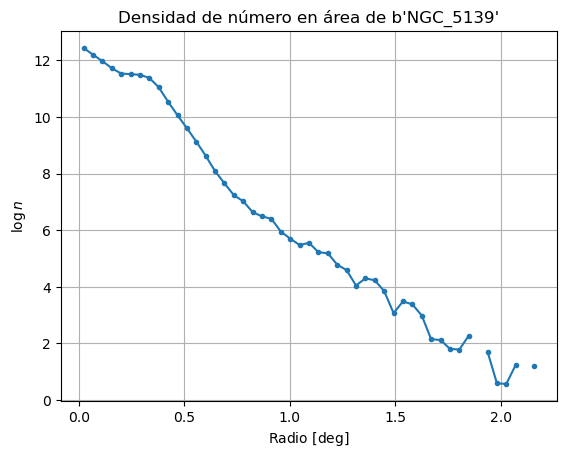

In [17]:
plt.plot(radii, np.log(densities), '.-')
plt.title(f"Densidad de número en área de {cluster_members['Name'][0]}")
plt.xlabel(r"Radio $[$deg$]$")
plt.ylabel(r'$\log{n}$')
plt.grid(True)
plt.show()

---
Se concatena la distancia de los miembros del cúmulo al punto más denso de este, a la tabla `cluster_members`, esto para poder calcular los datos pedidos de las estrellas en cada anillo.

In [18]:
cluster_members = pd.concat([cluster_members, d_members], axis=1)

La siguiente celda filtra cada estrella en su respectivo anillo, donde también se agrega una columna que indica en qué anillo está la respectiva estrella. En los anillos que no hay ninguna estrella, `pandas` no muestra las respectivas filas ya que no hay datos.

In [19]:
cluster_members_per_ring = cluster_members.head(0)
for i in range(len(rs)-1):
    i_ring = pd.DataFrame.copy(cluster_members[(rs[i] < cluster_members['d_members']) & (cluster_members['d_members'] <= rs[i+1])])
    if i_ring.shape[0] != 0:
        i_ring.loc[:,'ring'] = i
        cluster_members_per_ring = pd.concat([cluster_members_per_ring, i_ring], axis=0)

A continuación se hace un pivote usando el método de `pandas` `.pivot_table()`. Con esto se consigue tener las estadísticas de cada anillo, organizando la tabla de modo que cada anillo sea una fila con la estadística deseada para los datos de cada anillo. En este caso la estadística que se usa es la media, esto porque el método usado tiene el parámetro `aggfunc` donde su valor por defecto es la media.

In [20]:
cluster_members_per_ring_mean = cluster_members_per_ring[['ring', 'pmRA', 'pmDE', 'BP-RP', 'RV']].pivot_table(index='ring')

## Movimiento propio medio en ascención recta por anillo

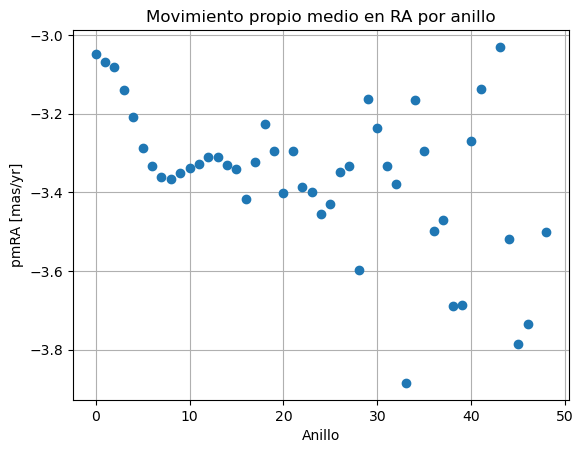

In [21]:
cluster_members_per_ring_mean['pmRA'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='pmRA [mas/yr]',
    title='Movimiento propio medio en RA por anillo',
    grid=True)
plt.show()

## Movimiento propio medio en declinación por anillo

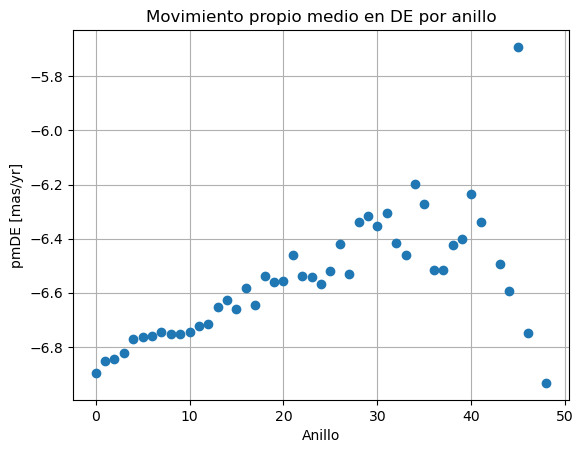

In [22]:
cluster_members_per_ring_mean['pmDE'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='pmDE [mas/yr]',
    title='Movimiento propio medio en DE por anillo',
    grid=True)
plt.show()

## Índice de color medio por anillo

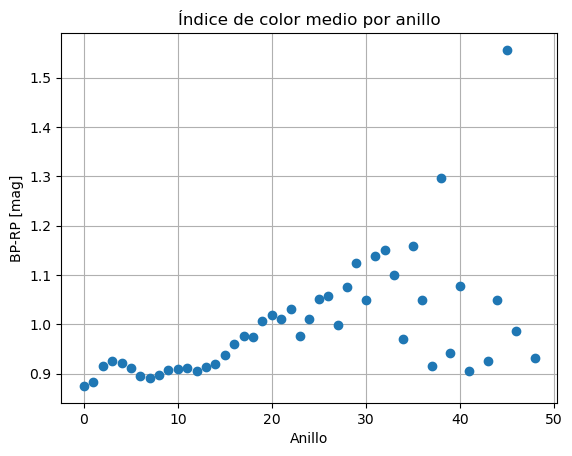

In [23]:
cluster_members_per_ring_mean['BP-RP'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='BP-RP [mag]',
    title='Índice de color medio por anillo',
    grid=True)
plt.show()

## Velocidad radial media por anillo

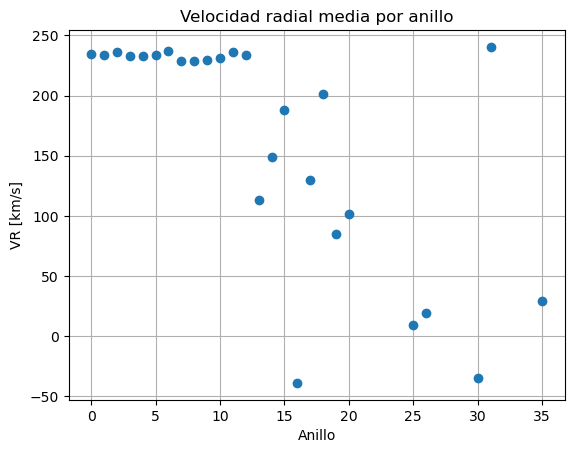

In [24]:
cluster_members_per_ring_mean['RV'].plot(
    style='o',
    xlabel='Anillo',
    ylabel='VR [km/s]',
    title='Velocidad radial media por anillo',
    grid=True)
plt.show()

---
# Densidad de número volumétrica

## Cálculo de distancias al punto más denso del cúmulo

Para calcular esta densidad se necesita encontrar la distancia a la que está cada estrella al centro del cúmulo. Como se trabaja en coordenadas esféricas, esta distancia se puede encontrar como: $$d = \sqrt{r_c^2 + r_s^2 - 2r_cr_s(\sin{\theta_c}\sin{\theta_s}cos{(\varphi_c-\varphi_s)} + \cos{\theta_c}\cos{\theta_s})}$$ donde $r_c$ es la distancia al cúmulo; $r_s$ es la distancia a la estrella; $\theta_i$ es la coordenada polar $i$, la cual es $180^\circ$ - $\text{RA}_i$, donde $\text{RA}_i$ es la respectiva ascención recta del cúmulo o estrella; $\varphi_i$ es la respectiva declinación del cúmulo o estrella.

Se calcula la distancia al cúmulo usando el paralaje de este dado por el catálogo (este paralaje es el paralaje medio).

In [25]:
p0 = clusters.iloc[cluster_n, 7]
d0 = Distance(parallax=p0*u.mas).value

Función que calcula la distancia, en parsecs, de las estrellas al centro del cúmulo.

In [26]:
def spherical_distance(r_cl, r_star, ra_cl, dec_cl, ra_star, dec_star):
    ra_cl = np.deg2rad(ra_cl)
    dec_cl = np.deg2rad(dec_cl)
    ra_star = np.deg2rad(ra_star)
    dec_star = np.deg2rad(dec_star)

    theta_cl = np.pi/2 - dec_cl
    theta_star = np.pi/2 - dec_star

    term = np.sin(theta_cl)*np.sin(theta_cl)*np.cos(dec_cl - dec_star) + np.cos(theta_cl)*np.cos(theta_star)
    distance = np.sqrt(r_cl**2 + r_star**2 - 2*r_cl*r_star*term)

    return distance


Se hallan las distancias de cada estrella del cúmulo y se agregan a la tabla de los miembros del cúmulo.

In [27]:
cluster_members['r_members'] = spherical_distance(
    d0, 
    cluster_members.loc[:, 'r_med_geo'], 
    ra0, 
    dec0, 
    cluster_members.loc[:, 'RA_ICRS'], 
    cluster_members.loc[:, 'DE_ICRS'])

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Cálculo de la densidad de número volumétrica

Se halla la distancia máxima.

In [28]:
d_max = cluster_members.loc[:, 'r_members'].max()

Se generan los radios de los cascarones hasta la distancia máxima para calcular la densidad de volumen por cascarones.

In [29]:
ds = np.linspace(0, d_max, 50)

Se definen dos funciones. `shell_vol()` calcula el volumenn de un cascaron con radios $r_1$ y $r_0$; `shell_dennsities()` que calcula la densidad de número por cascarones, donde los parámetros corresponden a: 
* `vols`: los volúmenes calculados para cada cascaron.
* `distances`: las distancias de las estrellas al cenntro del cúmulo. Por como se define esta función, este parámetro debe ser la columna de las distancias del data frame `cluster_members`.
* `radii`: radios de los cascarones.

In [30]:
def shell_vol(r0, r1):
    return 4/3*np.pi*(r1**3 - r0**3)

def shell_densities(vols, distances, radii):
    densities = np.zeros(len(radii)-1)
    for i in range(len(radii)-1):
        n = len(cluster_members[(radii[i] < distances) & (distances <= radii[i+1])])
        densities[i] = n/vols[i]
    return densities


In [31]:
radii = mean_radii(ds)
vols = shell_vol(ds[:-1], ds[1:])
densities = shell_densities(vols, cluster_members['r_members'], ds)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


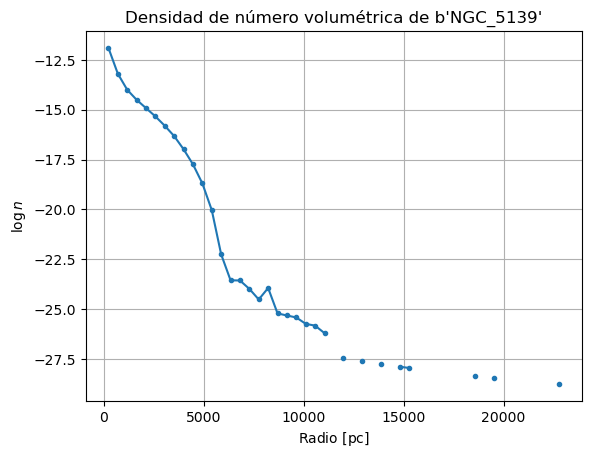

In [32]:
plt.plot(radii, np.log(densities), '.-')
plt.title(f"Densidad de número volumétrica de {cluster_members['Name'][0]}")
plt.xlabel(r"Radio $[$pc$]$")
plt.ylabel(r'$\log{n}$')
plt.grid(True)
plt.show()